# Interactivate Parameter Estimation

If a new material needs to be added are, or old parameters are updated with new data this notebook can be used.  
It will help to generate the Parameters needed to use the GM Model.


In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import sys

from scripts.plotting_functions import create_heatmap_plot, plot_gaussians
from scripts.preprocessor_functions import get_contrasts_from_dir
from scripts.annotation_class import watershed_annotator
from scripts.fitting_functions import fit_set
from scripts.postprocessing_functions import format_components

import time
import json

## Setting some constants

| Parameter             | Description                                                                                                                                    |
| --------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| `FLAKE_DIRECTORY`     | The directory path of the saved images; the images need to be in `.jpg` or `.png` format                                                       |
| `MASK_SAVE_DIRECTORY` | The directory path where the semantic masks are saved; these need to be in `.png` format                                                       |
| `ANNOTATE`            | If the images are already annotated or not, if you want to annotate images and save the results to `MASK_SAVE_DIRECTORY` toggle this to `TRUE` |
| `USE_FLATFIELD`       | Whether to use a flatfield image or not                                                                                                        |
| `FLATFIELD_PATH`      | The Path to the flatfield image                                                                                                                |
| `USED_CHANNELS `      | The channels used to fit the GM-Model, if, for example, your Blue Channel is Weak you may want to only use `RG`                                |
| `AXIS_NAMES`          | The names used when plotting for the axes                                                                                                      |

As the Supplied Datasets already have their flatfield removed, the default for `USE_FLATFIELD` is set to `False`.  
If you want to use a flatfield image, you need to set `USE_FLATFIELD` to `True` and set the path to the flatfield image in `FLATFIELD_PATH`.


In [2]:
FLAKE_DIRECTORY = r"../CenteredGraphene/data"
MASK_SAVE_DIRECTORY = r"../CenteredGraphene/masks"
ANNOTATE = True
USE_FLATFIELD = False
FLATFIELD_PATH = r"C:/Path/To/flatfield.png"
USED_CHANNELS = "BGR"
AXIS_NAMES = ["Blue Contrast", "Green Contrast", "Red Contrast"]

## Checking if the given Parameters are valid


In [3]:
assert os.path.exists(FLAKE_DIRECTORY), "Flake directory does not exist"
if USE_FLATFIELD:
    assert os.path.exists(FLATFIELD_PATH), "Flatfield image does not exist"

assert len(USED_CHANNELS) in [2, 3], "We need 2 or 3 channels for the GMM"

os.makedirs(MASK_SAVE_DIRECTORY, exist_ok=True)

## Annotating the Images in the Folder

The annotator uses the watershed algorithm to discern the foreground from the background.  
It is only necessary to define these two classes as the thickness is inferred later by the clustering.

A red outline is shown between the background and foreground indicating the mask boundry.

The Masks are saved as `.png` files in the `MASK_SAVE_DIRECTORY` Folder with the same name as the image.

### Controls

|            Keys             | Description                                                  |
| :-------------------------: | ------------------------------------------------------------ |
| <kbd>A</kbd> / <kbd>D</kbd> | Previous / Next Image                                        |
|        <kbd>S</kbd>         | Save the current annotion, very important after every image! |
|        <kbd>C</kbd>         | Delete the current annotations                               |
|    <kbd>Left MBT </kbd>     | Set a marker for foreground                                  |
|    <kbd>Right MBT </kbd>    | Set a marker for background                                  |
|       <kbd>ESC</kbd>        | Exit the program                                             |


In [4]:
if ANNOTATE:
    annotator = watershed_annotator(
        image_directory=FLAKE_DIRECTORY,
        mask_directory=MASK_SAVE_DIRECTORY,
    )
    annotator.run()

## Loading the Contrast Values into Memory

The `get_contast_from_dir` function checks the directory for masks and their corresponding images.  
If the `USE_FLATFIELD` is enabled it will also look for the flatfield image and remove it from the image.  
If the images already have their flatfield removed set it to `False`.


In [5]:
datapoints_contrast = get_contrasts_from_dir(
    image_directory=FLAKE_DIRECTORY,
    mask_directory=MASK_SAVE_DIRECTORY,
    use_flatfield=USE_FLATFIELD,
    flatfield_path=FLATFIELD_PATH,
)

## Plotting the raw data

As a first step a heatmap is generated to confirm the clustering of each thickness.  
This clustering may be very faint is there are not enough points for a certain thickness.  
If the generated heatmap looks off you can change the plotting paramters.  
The parameters are:
- `sigma` is the standard deviation of the gaussian kernel used to smooth the heatmap.
  - Changing it will change the apparent size of the clusters.
- `bins` is the number of bins used to generate the heatmap.
  - Changing it will change the resolution of the heatmap. Higher Resoltions may show higher detail but can also show more noise.  

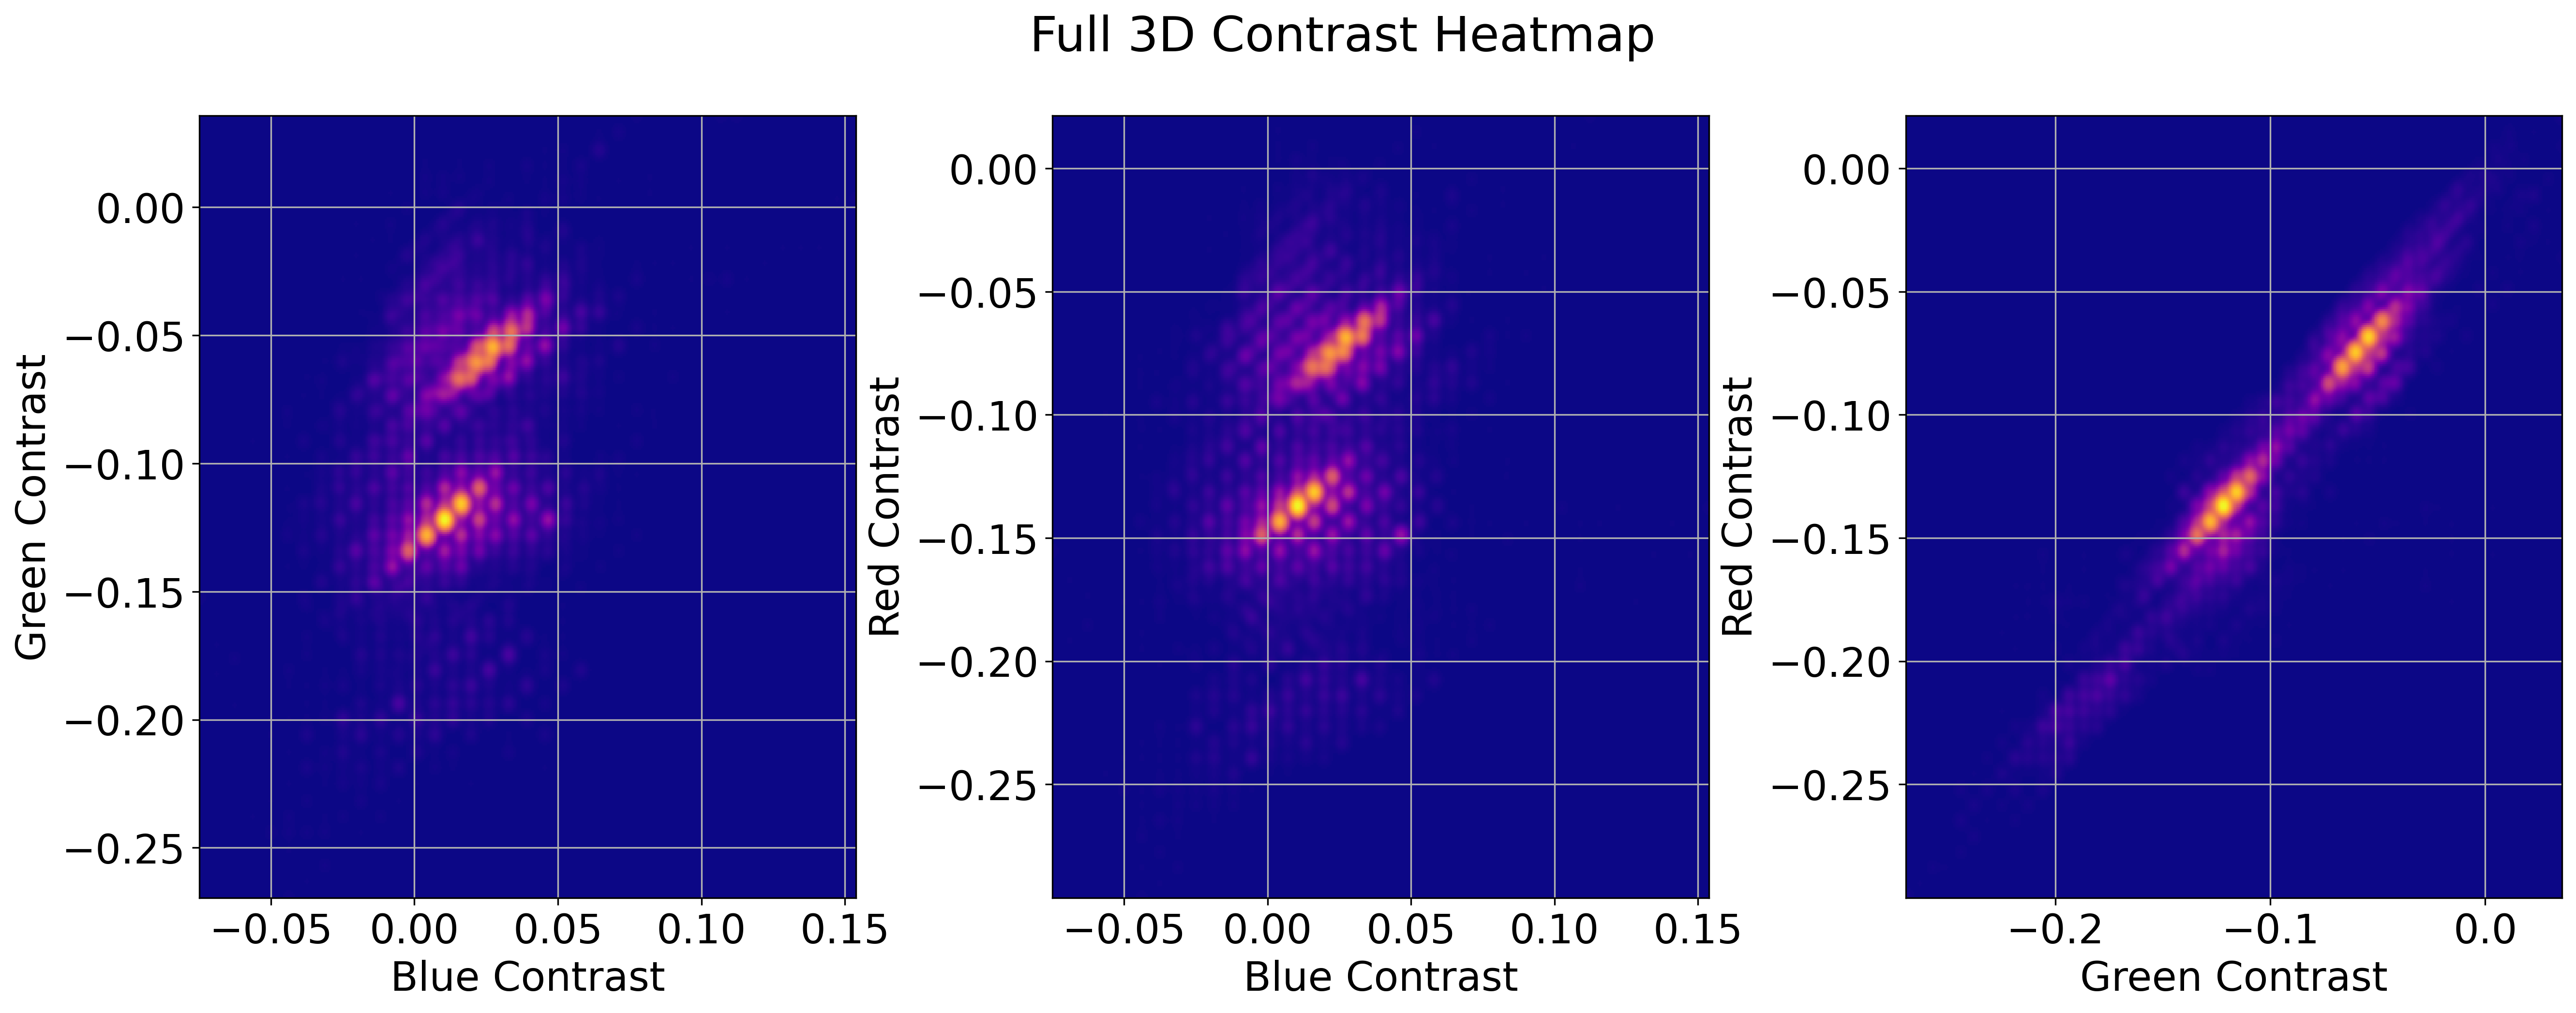

In [6]:
create_heatmap_plot(
    data=datapoints_contrast,
    axis_names=AXIS_NAMES,
    sigma=3,
    bins=400,
    used_channels=USED_CHANNELS,
)

## Cropping the Arrays

To improve the accuracy of the GMM the data is first cropped to remove unneccessary noise or unwanted thicknesses.  
For this the upper and lower bounds of the contrasts need to be defined.  
These values can be read of the plot above.



Number of Data Points: 28441
Cropped Number of Data Points: 3457


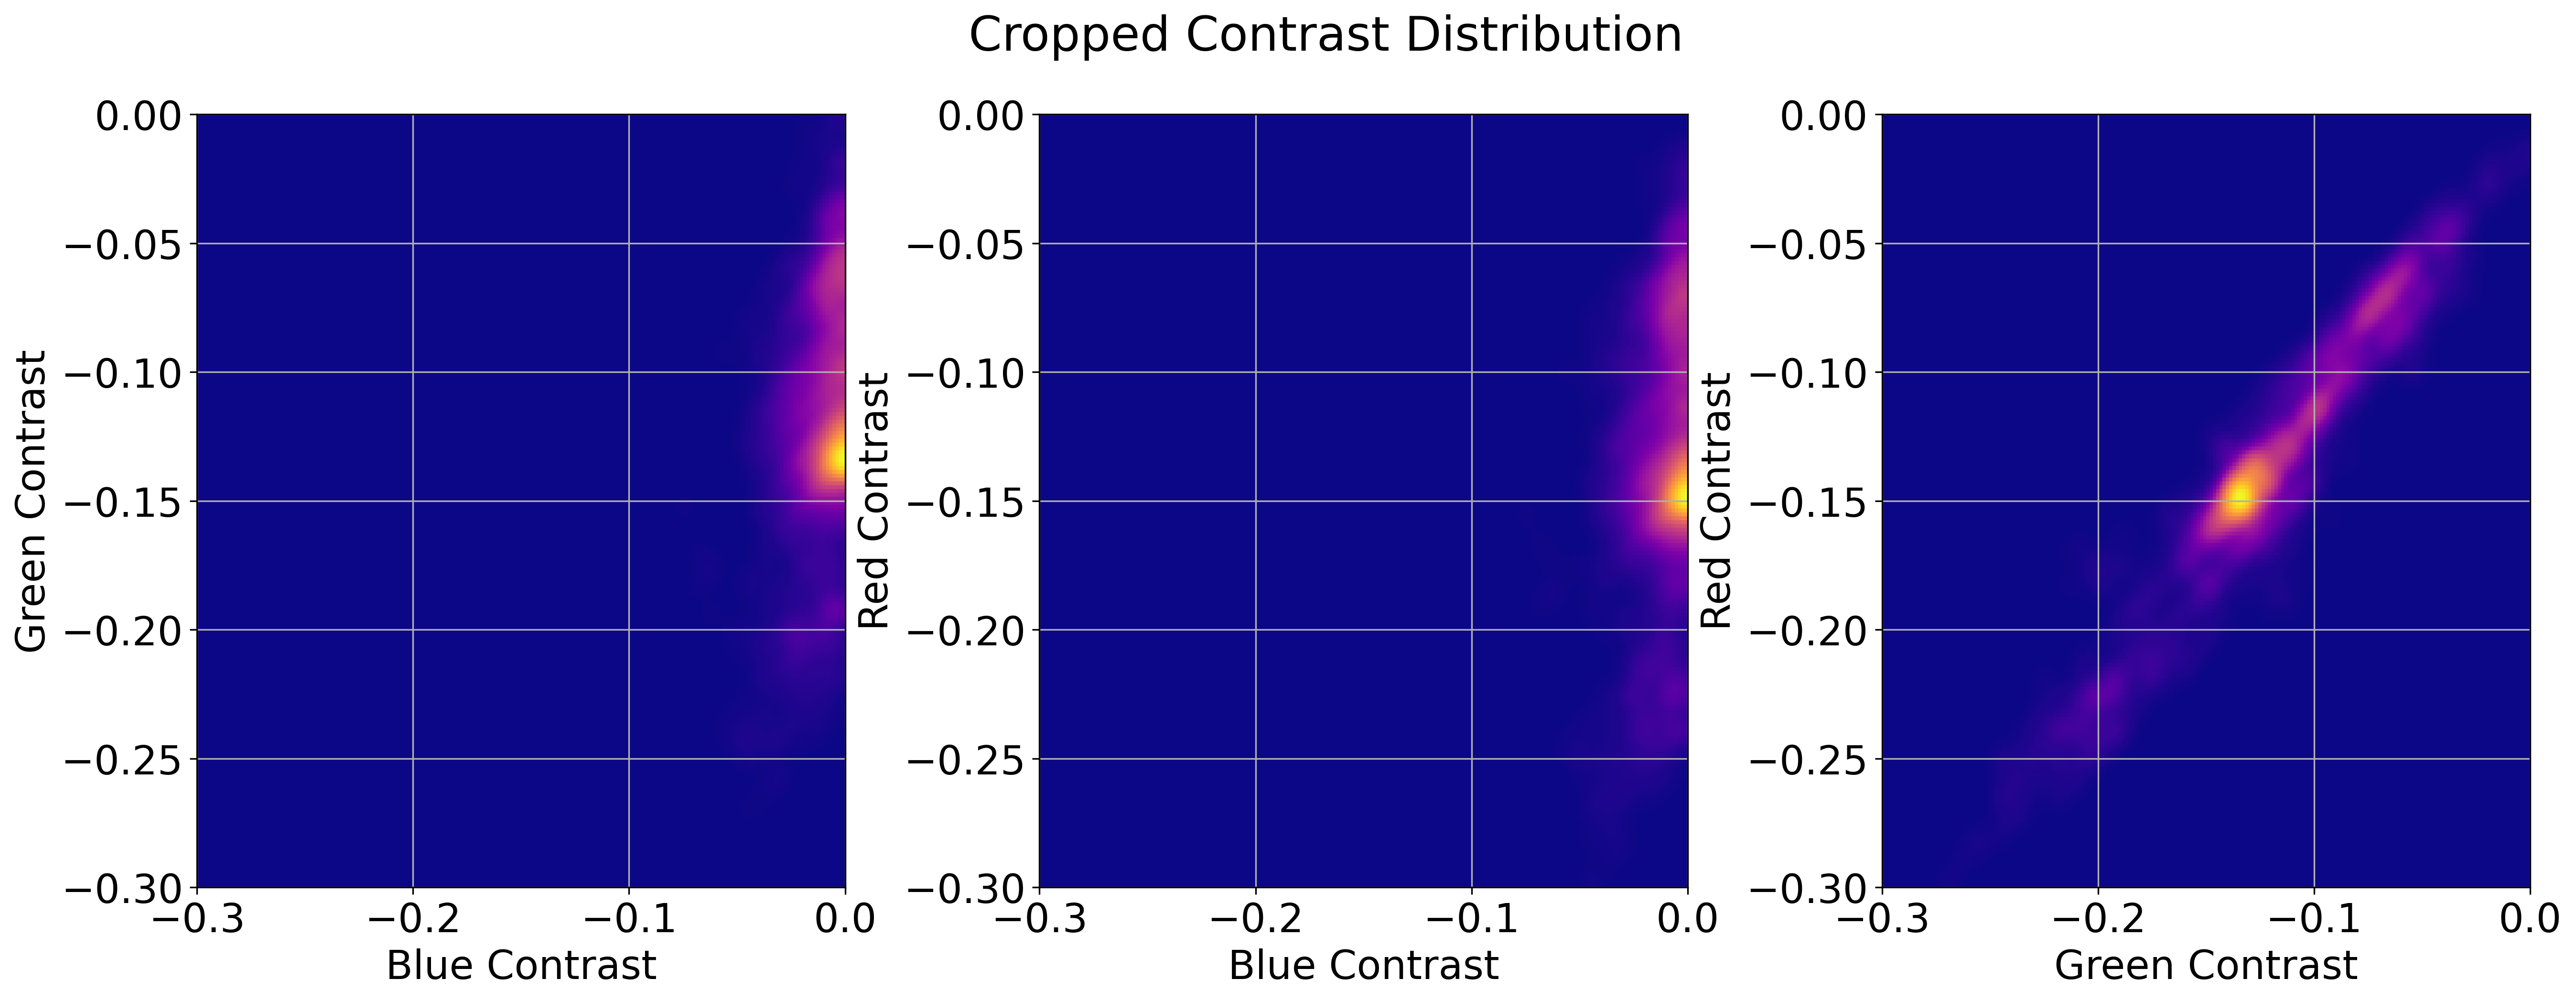

In [7]:
# cropping the contrast array
upper_bounds = [0, 0, 0]  # B,G,R
lower_bounds = [-0.3, -0.3, -0.3]  # B,G,R

datapoints_contrast_cropped = datapoints_contrast[
    (datapoints_contrast[:, 0] > lower_bounds[0])
    & (datapoints_contrast[:, 0] < upper_bounds[0])
    & (datapoints_contrast[:, 1] > lower_bounds[1])
    & (datapoints_contrast[:, 1] < upper_bounds[1])
    & (datapoints_contrast[:, 2] > lower_bounds[2])
    & (datapoints_contrast[:, 2] < upper_bounds[2])
]

print(f"\nNumber of Data Points: {len(datapoints_contrast)}")
print(f"Cropped Number of Data Points: {len(datapoints_contrast_cropped)}")

create_heatmap_plot(
    data=datapoints_contrast_cropped,
    axis_names=AXIS_NAMES,
    sigma=3,
    bins=200,
    upper_bounds=upper_bounds,
    lower_bounds=lower_bounds,
    title="Cropped Contrast Distribution",
    used_channels=USED_CHANNELS,
)

## Fitting the Gaussian Mixture Model

Now the Gaussian Mixture Model (GMM) is fitted.

### Parameter Explanation

| Parmeter                                | Description                                                                                                  |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| <code>NUMBER_OF_COMPONENTS</code>       | The number of expected Thickness clusters                                                                    |
| <code>NUMBER_OF_NOISE_COMPONENTS</code> | The number of extra gaussian components to fit noise                                                         |
| <code>SAMPLE_SIZE</code>                | The number of sampled points from the data, can be set to <code>None</code> to use all data                  |
| <code>COV_TYPE</code>                   | The type of used covariance Matrix, supported values <code>full</code>, <code>tied</code>, <code>diag</code> |
| <code>INITIAL_MEANS</code>              | The initial means of the GMM, can be set to <code>None</code> to use the default initialization; if used the length of the initial means has to match the total number of components used and in the format `BGR`             |

Under the hood we are using the SciKit-Learn implementation of the EM-Algorithm. For more information see the [SciKit-Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

### Tips

- If the generated Gaussians are to large, try increasing the number of noise components.
- If the Gaussians are off by the mean, try setting the initial means by reading them off the plot.
- If the Gaussians still look off you may need to collect more data. Five flakes per thickness with atleast 1000px is a good rule of thumb.
- If training takes too long, reduce the sample size. A good value is `30000`.


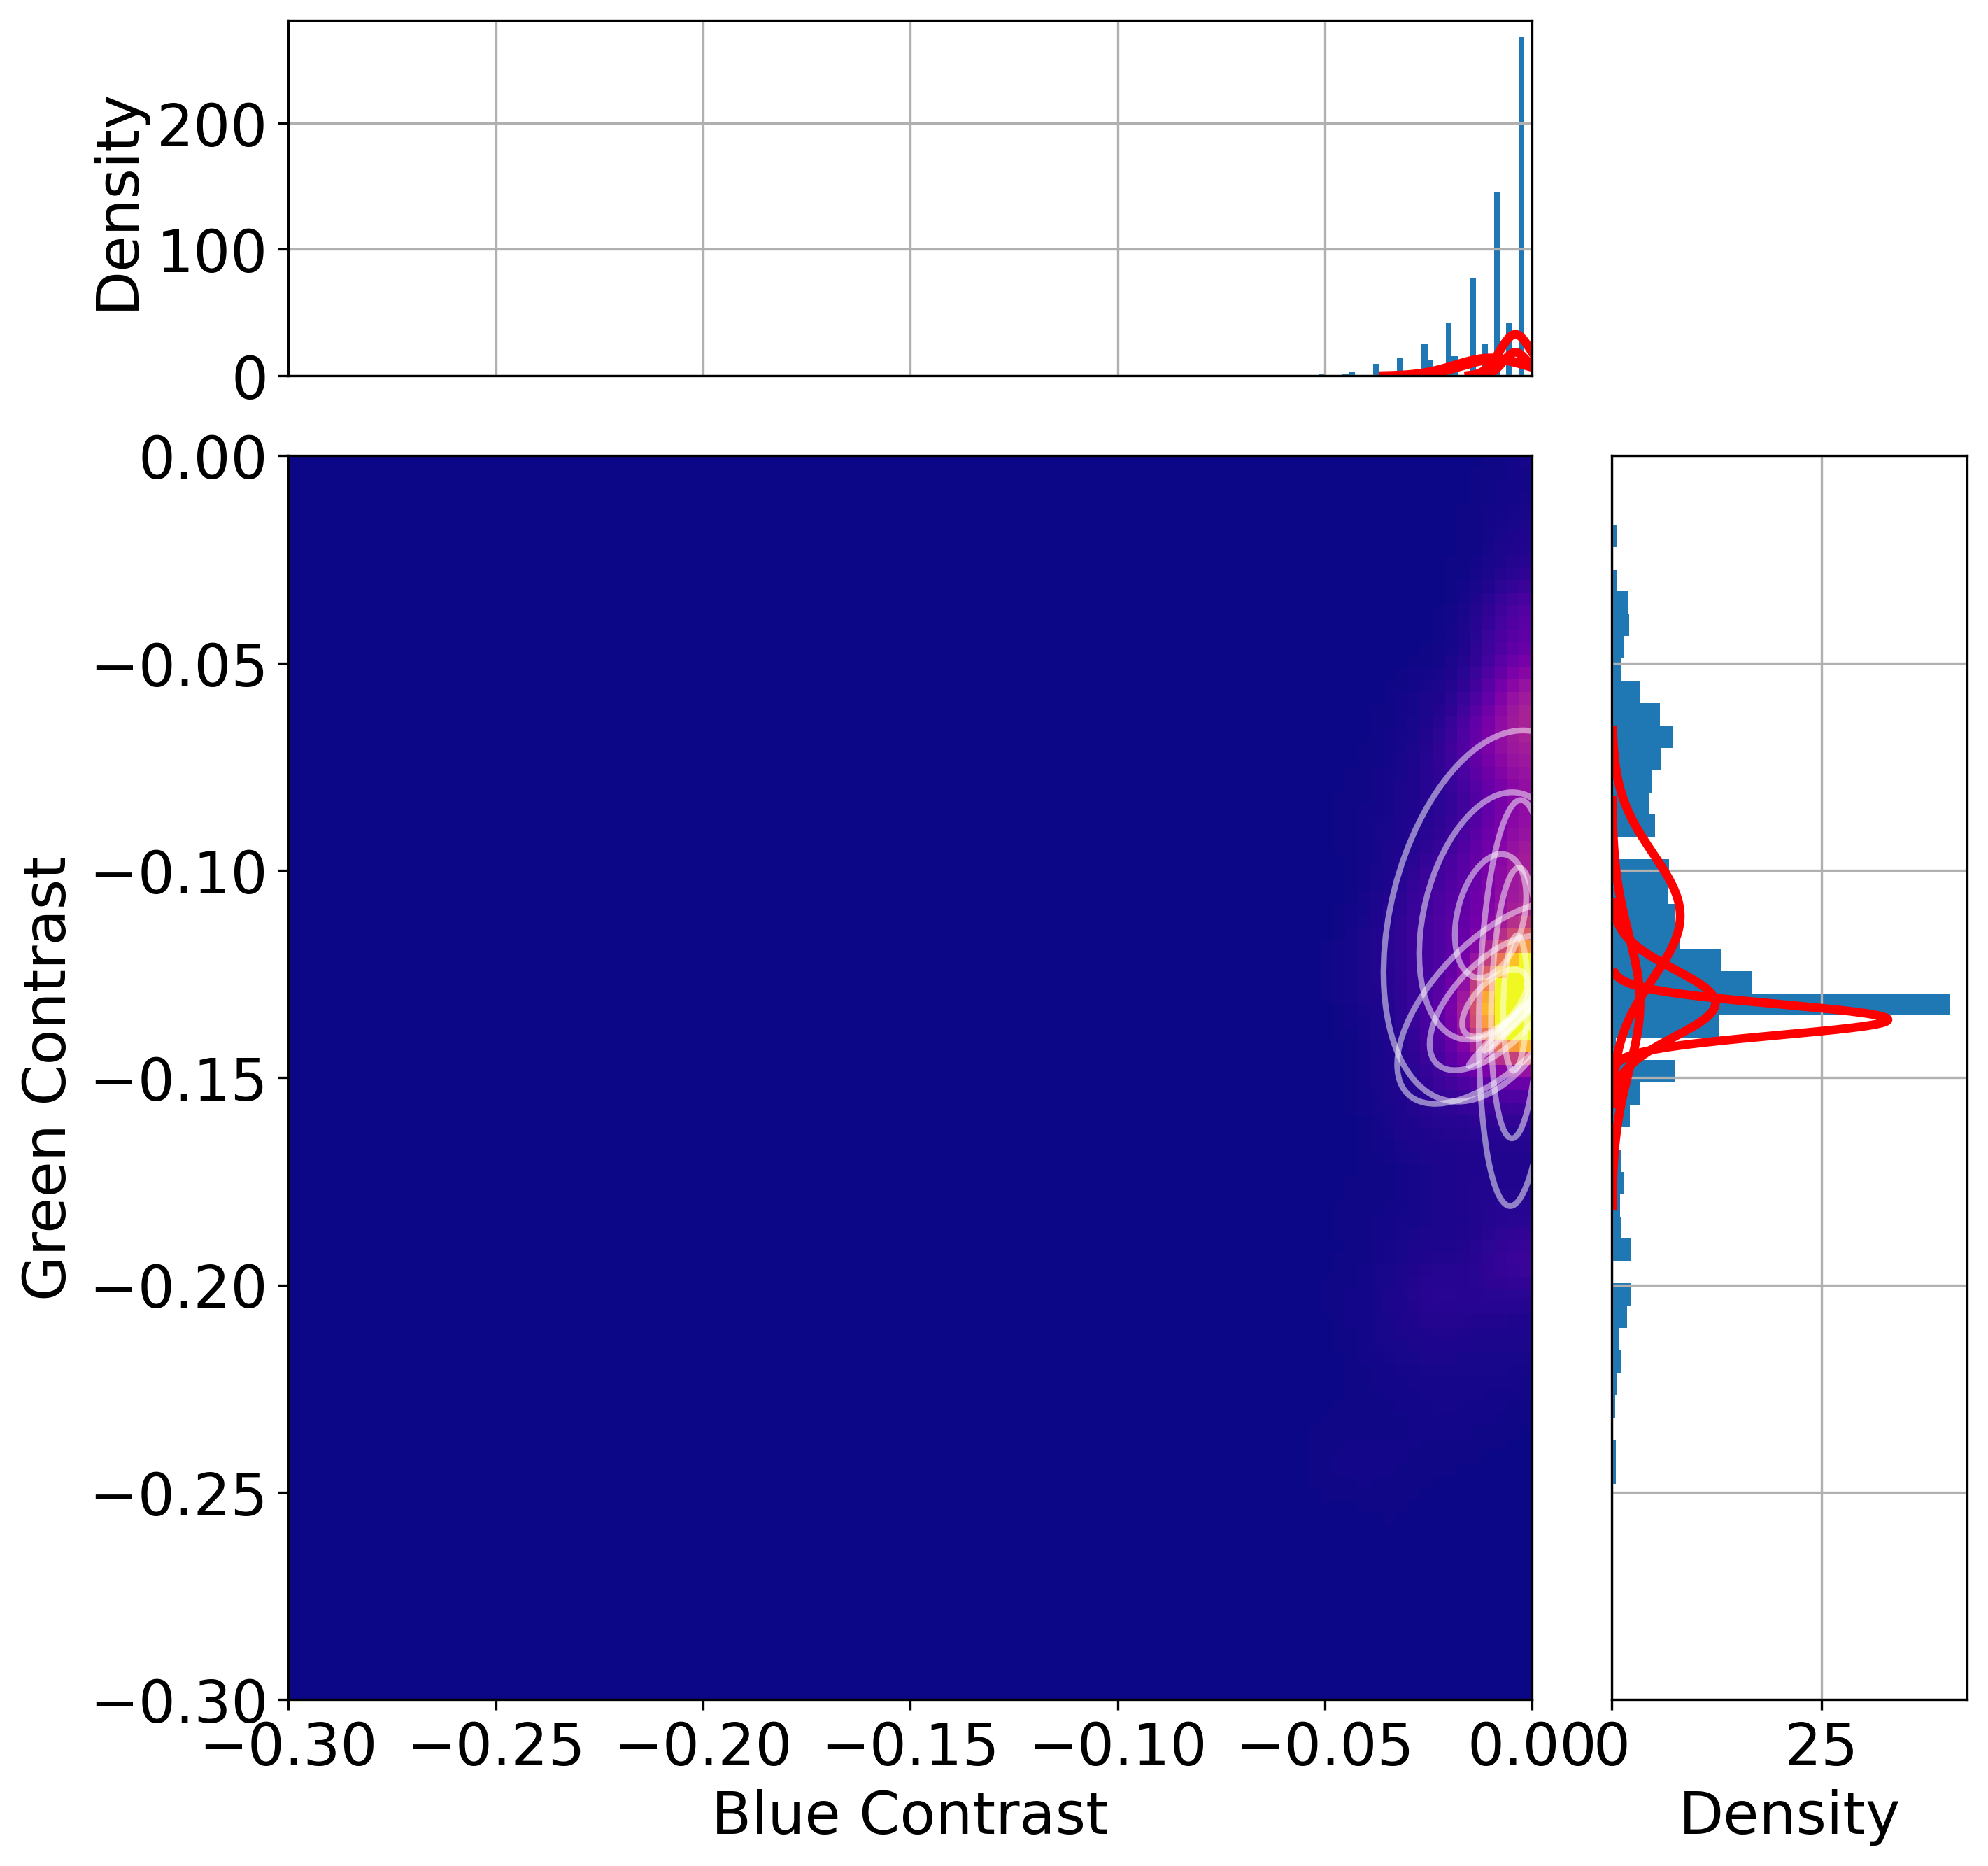

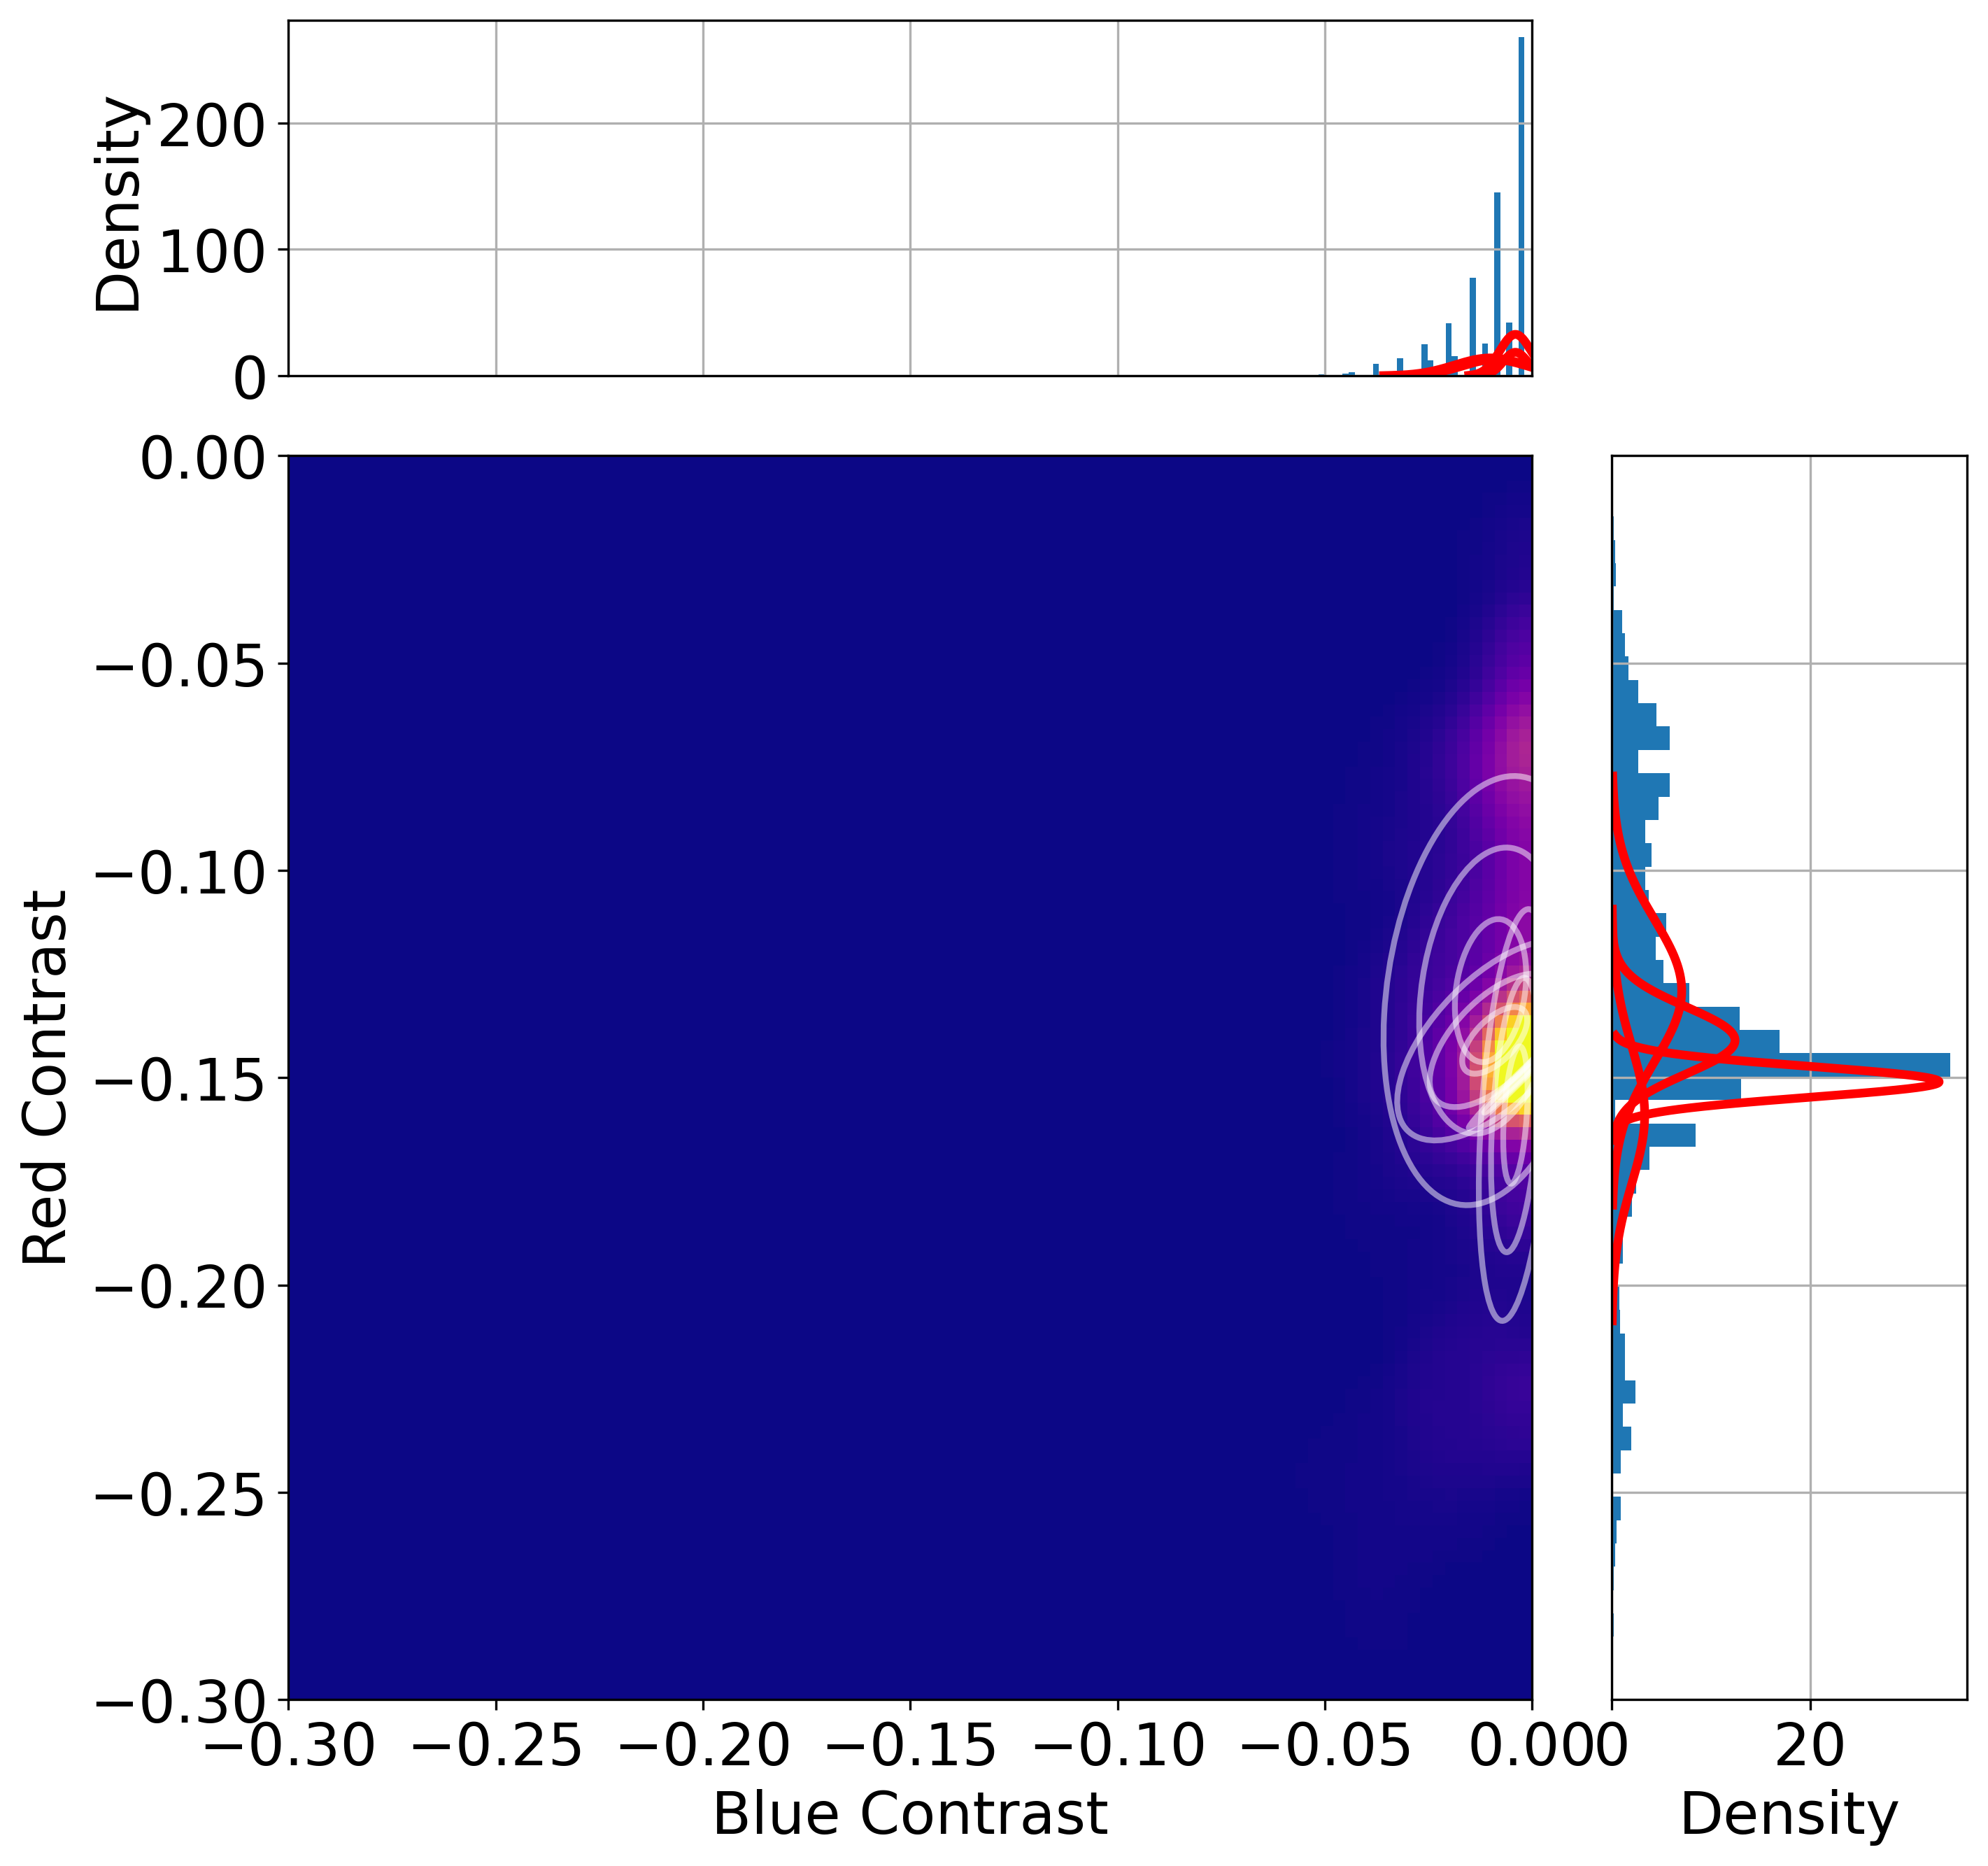

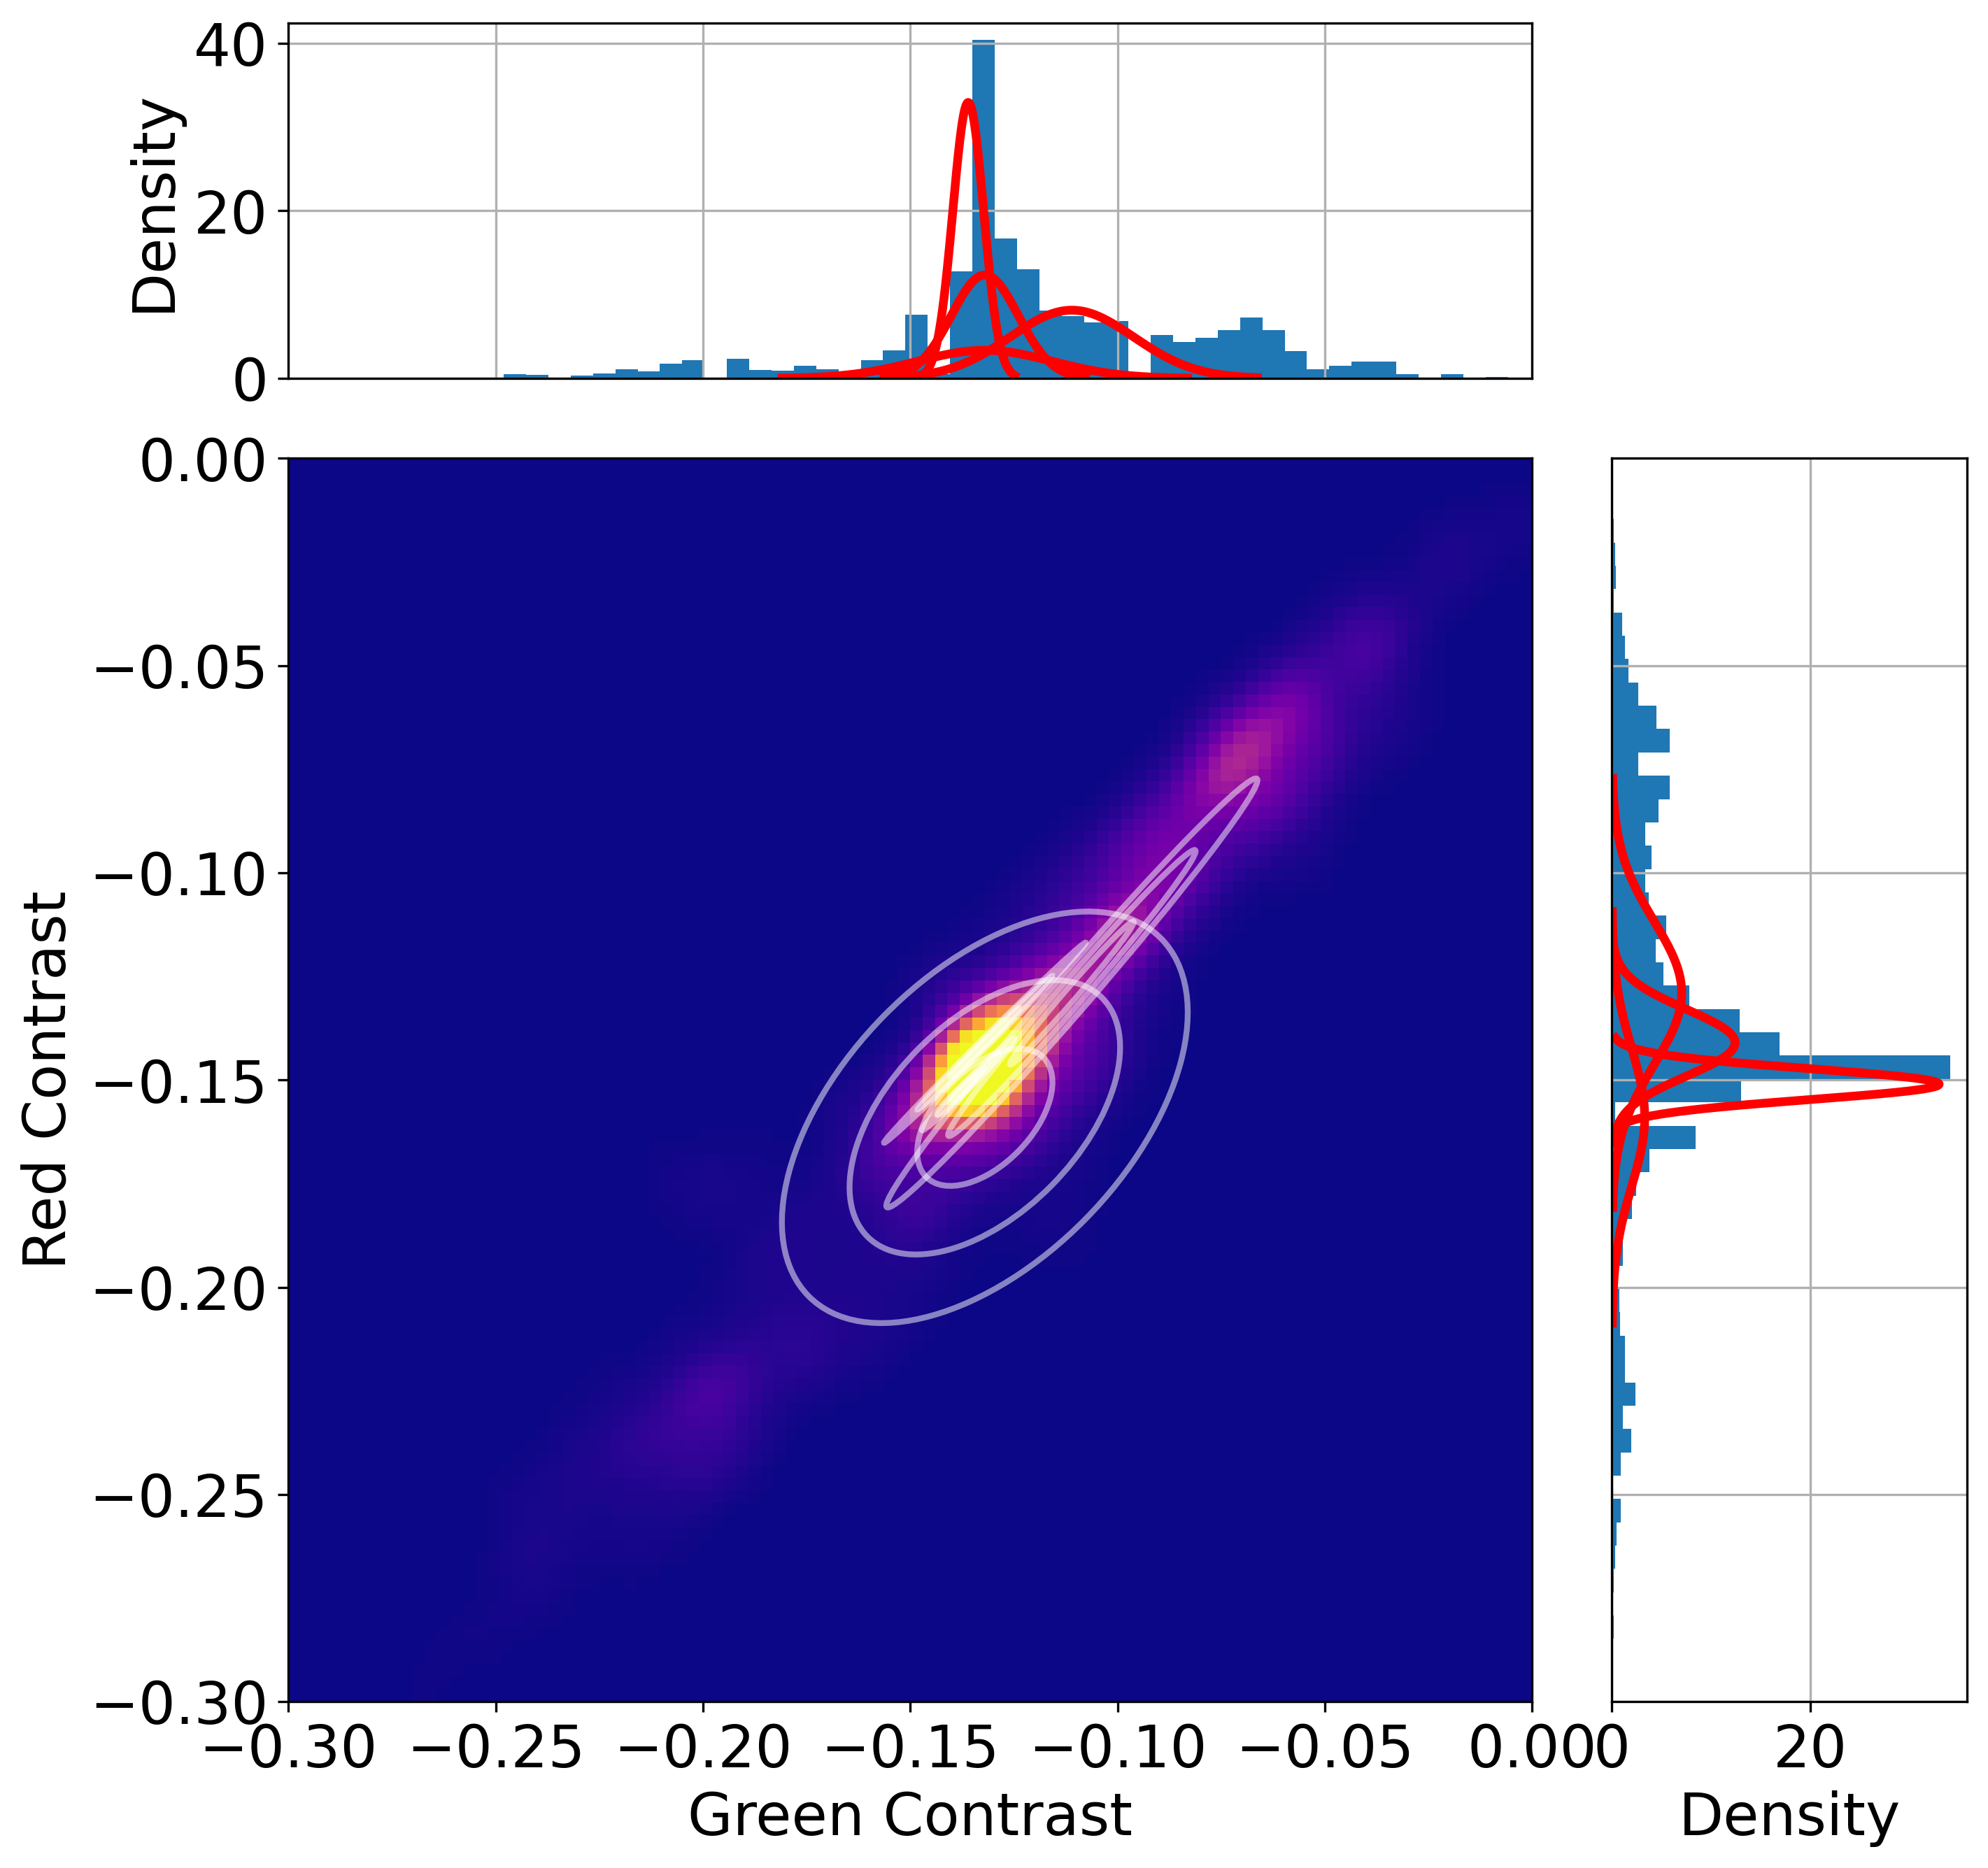

In [8]:
NUMBER_OF_COMPONENTS = 4
NUMBER_OF_NOISE_COMPONENTS = 4
SAMPLE_SIZE = None
COV_TYPE = "full"

# unused, only used for demonstration
INITIAL_MEANS = [
    [-0.22, -0.37, -0.35],
    [-0.07, -0.14, -0.14],
    [-0.15, -0.26, -0.25],
    [-0.27, -0.47, -0.44],
    [-0.20, -0.20, -0.20],  # The noise component
]

(
    all_means_gauss,
    all_covariances_gauss,
    all_weights_gauss,
    sampled_data,
    predicted_labels,
) = fit_set(
    data=datapoints_contrast_cropped,
    num_components=NUMBER_OF_COMPONENTS,
    num_additional_noise_comp=NUMBER_OF_NOISE_COMPONENTS,
    cov_type=COV_TYPE,
    sample_size=SAMPLE_SIZE,
    used_channels=USED_CHANNELS,
    # initial_means=INITIAL_MEANS, # uncomment to use custom initial means
)

plot_gaussians(
    data=sampled_data,
    predicted_labels=predicted_labels,
    gauss_means=all_means_gauss,
    gauss_weights=all_weights_gauss,
    gauss_covariances=all_covariances_gauss,
    axis_names=AXIS_NAMES,
    upper_bounds=upper_bounds,
    lower_bounds=lower_bounds,
    bins=50,
    fig_size=(10, 10),
    plot_type="heatmap",
    heatmap_bins=100,
    heatmap_sigma=2,
    used_channels=USED_CHANNELS,
);

## Generate the JSON with the given Parameters

After the JSON is generated it may be necessary to order and rename each of the components.  
The json file will be saved in the same directory as the notebook, but you can change the path in the code below.


In [9]:
component_dict = format_components(all_means_gauss, all_covariances_gauss)

with open("gaussian_mixture_model_contrast_data.json", "w") as f:
    json.dump(component_dict, f, indent=4, sort_keys=True)